# Classifying Disaster-Related Tweets as Real or Fake

In this project, we’ll be working as a data scientist for a news analytics company interested in monitoring and analyzing news on social media platforms to look for misinformation. One of the most popular platforms is Twitter, which has become an important communication channel in times of emergency.

In this context, our task is to build a deep learning text classification model that predicts which Tweets are about real disasters and which aren’t. The dataset comes from Kaggle.

## Data Description

We'll be using the train.csv and test.csv datasets that contain five columns:

**id**: a unique identifier for each tweet

**keyword**: a particular keyword from the tweet (may be blank)

**location**: the location the tweet was sent from (may be blank)

**text**: the text of the tweet

**target**: denotes whether a tweet is about a real disaster (1) or not (0). This is the target variable.

### Download Data

In [39]:
# Import libraries
import numpy as np 
import pandas as pd
import tensorflow as tf
# import tensorflow_datasets as tfds
# import datasets
# import transformers
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud

# import tensorflow 
# print(tensorflow.__version__)
# from tensorflow.keras import Input
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import TextVectorization, Embedding, LSTM, Dense, Bidirectional
# from tensorflow.keras.regularizers import L1, L2, L1L2
# from tensorflow.keras.optimizers import Adam, RMSprop

# from datasets import load_dataset
# from transformers import AutoTokenizer
# from transformers import TFAutoModelForSequenceClassification
#!wget https://dsserver-prod-resources-1.s3.amazonaws.com/nlp/train.csv

In [4]:
#Import train set
df = pd.read_csv("train.csv")
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
df.tail()

,id,keyword,location,text,target
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


In [6]:
print(df.shape)
print(df.columns)

(7613, 5)
Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [8]:
# Check for missing data
df.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [9]:
# Unique values in each of the dataset variables
df.nunique()

id          7613
keyword      221
location    3341
text        7503
target         2
dtype: int64

## Data Exploration

In [10]:
# Drop the variables that are not useful for modelling
df = df.drop(['id','keyword', 'location'], axis=1)
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7613 non-null   object
 1   target  7613 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 119.1+ KB
None
                                                text  target
0  Our Deeds are the Reason of this #earthquake M...       1
1             Forest fire near La Ronge Sask. Canada       1
2  All residents asked to 'shelter in place' are ...       1
3  13,000 people receive #wildfires evacuation or...       1
4  Just got sent this photo from Ruby #Alaska as ...       1


In [11]:
# Use the distribution of the target variable to determine if on an average a tweet tends to indicate disaster or not
df.target.value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [12]:
# Percentage of values of the target variable
df['target'].value_counts(normalize=True)

target
0    0.57034
1    0.42966
Name: proportion, dtype: float64

C:\Users\My Pham\AppData\Local\Temp\ipykernel_19892\3399858805.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='target', data=df, palette='deep')


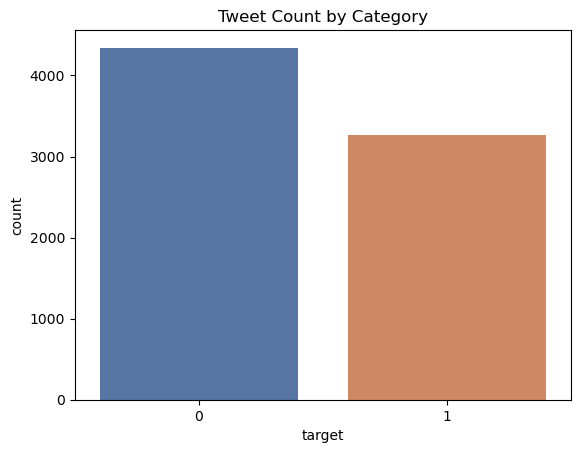

In [13]:
# Visualize the distribution of the target variable
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x='target', data=df, palette='deep')
plt.title('Tweet Count by Category')
plt.show()

We can see approximately 43% of the tweets were indicative of real disaster, and we can also see that the data is fairly balanced. We have also dropped some of the variables that might not carry predictive power. it's a text classification model we are dealing with, so the two variables of interest now are the target and the text variables.

## Text Preprocessing

In [18]:
# Import libraries
import re
import nltk
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt_tab to C:\Users\My
[nltk_data]     Pham\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package stopwords to C:\Users\My
[nltk_data]     Pham\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\My
[nltk_data]     Pham\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\My
[nltk_data]     Pham\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [19]:
# Lowercase the text in the text column
df['text'] = df['text'].str.lower()
df['text']

0       our deeds are the reason of this  earthquake m...
1                  forest fire near la ronge sask  canada
2       all residents asked to  shelter in place  are ...
3              people receive  wildfires evacuation or...
4       just got sent this photo from ruby  alaska as ...
                              ...                        
7608    two giant cranes holding a bridge collapse int...
7609     aria ahrary  thetawniest the out of control w...
7610    m            utc   km s of volcano hawaii  htt...
7611    police investigating after an e bike collided ...
7612    the latest  more homes razed by northern calif...
Name: text, Length: 7613, dtype: object

In [22]:
# Remove punctuations and numbers from the text
def punc(inputs):
    return re.sub(r'[^a-zA-Z]', ' ', inputs)

df['text'] = df['text'].apply(punc)
df['text'].head()

0    our deeds are the reason of this  earthquake m...
1               forest fire near la ronge sask  canada
2    all residents asked to  shelter in place  are ...
3           people receive  wildfires evacuation or...
4    just got sent this photo from ruby  alaska as ...
Name: text, dtype: object

In [23]:
# Tokenize the text into individual words
def tokenization(inputs):
    return word_tokenize(inputs)

df['text_tokenized'] = df['text'].apply(tokenization)
df['text_tokenized'].head()

0    [our, deeds, are, the, reason, of, this, earth...
1        [forest, fire, near, la, ronge, sask, canada]
2    [all, residents, asked, to, shelter, in, place...
3    [people, receive, wildfires, evacuation, order...
4    [just, got, sent, this, photo, from, ruby, ala...
Name: text_tokenized, dtype: object

In [25]:
# Remove stopwords from the tokenized text
stop_words = set(stopwords.words('english'))
stop_words.remove('not')

def rm_stop(inputs):
    return [i for i in inputs if i not in stop_words]

df['text_stop'] = df['text_tokenized'].apply(rm_stop)
df['text_stop'].head()

0    [deeds, reason, earthquake, may, allah, forgiv...
1        [forest, fire, near, la, ronge, sask, canada]
2    [residents, asked, shelter, place, notified, o...
3    [people, receive, wildfires, evacuation, order...
4    [got, sent, photo, ruby, alaska, smoke, wildfi...
Name: text_stop, dtype: object

In [26]:
# Lemmatize the words in the tokenized text
lemmatizer = WordNetLemmatizer()

def lemmatization(inputs):
    return [lemmatizer.lemmatize(word = k, pos = 'v') for k in inputs]

df['text_lemmatized'] = df['text_stop'].apply(lemmatization)
df['text_lemmatized'].head()

0    [deeds, reason, earthquake, may, allah, forgiv...
1        [forest, fire, near, la, ronge, sask, canada]
2    [residents, ask, shelter, place, notify, offic...
3    [people, receive, wildfires, evacuation, order...
4    [get, send, photo, ruby, alaska, smoke, wildfi...
Name: text_lemmatized, dtype: object

In [27]:
# Join the lemmatized tokens into sentences
df['final'] = df['text_lemmatized'].str.join(' ')
df['final'].head()

0         deeds reason earthquake may allah forgive us
1                forest fire near la ronge sask canada
2    residents ask shelter place notify officer eva...
3    people receive wildfires evacuation order cali...
4    get send photo ruby alaska smoke wildfires pou...
Name: final, dtype: object

In [28]:
df.head()

,text,target,text_tokenized,text_stop,text_lemmatized,final
0,our deeds are the reason of this earthquake m...,1,"[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...","[deeds, reason, earthquake, may, allah, forgiv...",deeds reason earthquake may allah forgive us
1,forest fire near la ronge sask canada,1,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]",forest fire near la ronge sask canada
2,all residents asked to shelter in place are ...,1,"[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...","[residents, ask, shelter, place, notify, offic...",residents ask shelter place notify officer eva...
3,people receive wildfires evacuation or...,1,"[people, receive, wildfires, evacuation, order...","[people, receive, wildfires, evacuation, order...","[people, receive, wildfires, evacuation, order...",people receive wildfires evacuation order cali...
4,just got sent this photo from ruby alaska as ...,1,"[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...","[get, send, photo, ruby, alaska, smoke, wildfi...",get send photo ruby alaska smoke wildfires pou...


We can see the transformation of **text** column into **final** column post all the processing steps. This processed text is more suitable for building text classification models.

## WordCloud

In [30]:
# Filter for disaster and non-disaster tweets
disaster = df[df['target'] == 1]
not_disaster = df[df['target'] == 0]

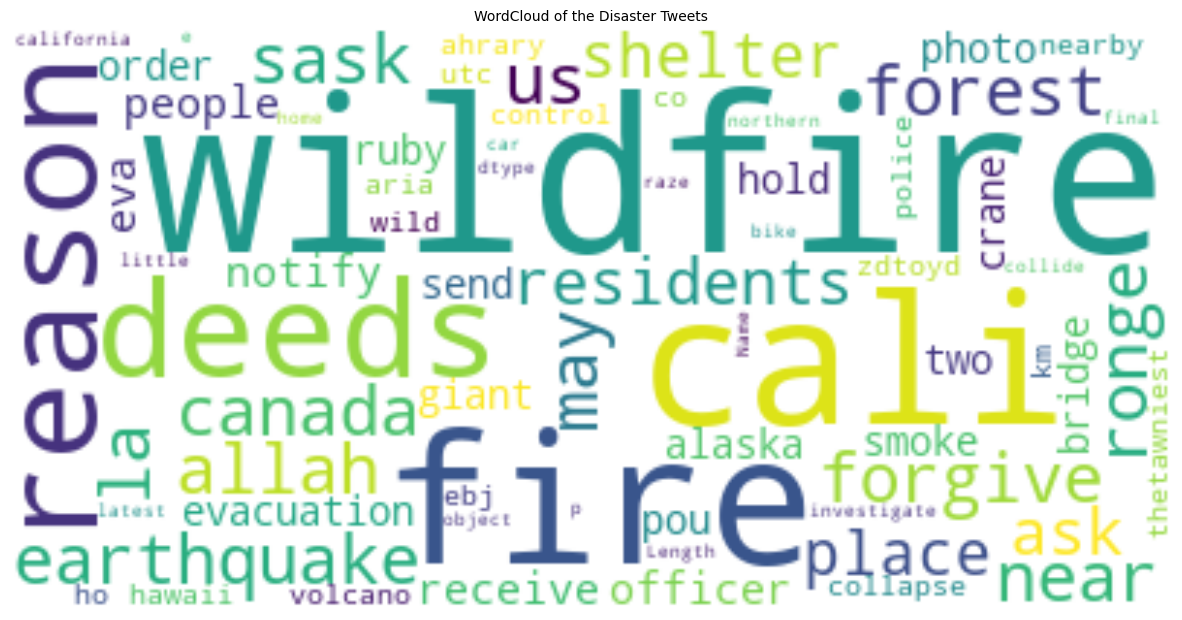

In [31]:
# Generate disaster WordCloud
from wordcloud import WordCloud

WordCloud_disaster = WordCloud(max_words=500, random_state=100, background_color='white',
                                collocations=True).generate(str((disaster['final'])))

plt.figure(figsize=(15, 10))
plt.imshow(WordCloud_disaster, interpolation='bilinear')
plt.title('WordCloud of the Disaster Tweets', fontsize=10)
plt.axis("off")
plt.show()

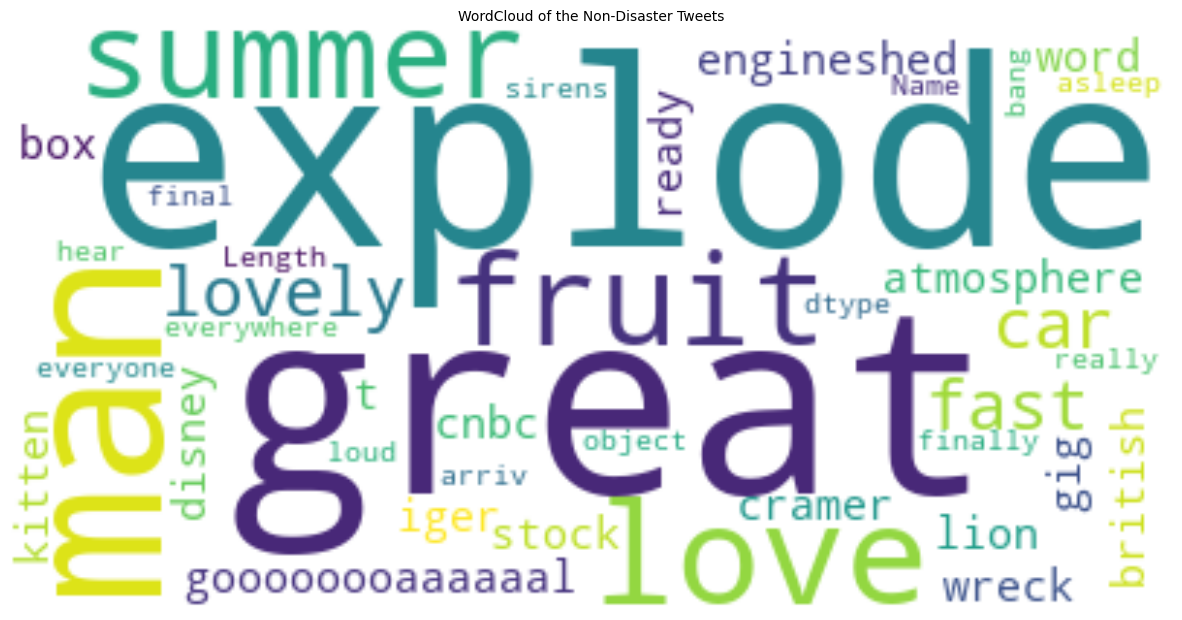

In [33]:
# Generate non-disaster WordCloud
from wordcloud import WordCloud

WordCloud_not_disaster = WordCloud(max_words=500, random_state=100, background_color='white',
                                collocations=True).generate(str((not_disaster['final'])))

plt.figure(figsize=(15, 10))
plt.imshow(WordCloud_not_disaster, interpolation='bilinear')
plt.title('WordCloud of the Non-Disaster Tweets', fontsize=10)
plt.axis("off")
plt.show()

If we examine the wordcloud for disaster and non-disaster related tweets, we can see there are certain words that are more frequent in these respective tweets. This difference is sometimes useful in understanding the intricacies of the data and visually presenting it!

## Build a shallow neural network

In [42]:
# Create an array of the target (dependent) variable and an array for the predictor (independent) variable
X = df['final']
y = df['target']

print(X.head())
print(y.head())

0         deeds reason earthquake may allah forgive us
1                forest fire near la ronge sask canada
2    residents ask shelter place notify officer eva...
3    people receive wildfires evacuation order cali...
4    get send photo ruby alaska smoke wildfires pou...
Name: final, dtype: object
0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int64


In [43]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (6090,) (6090,)
Testing set shape: (1523,) (1523,)


In [44]:
# Instantiate a model with the Keras Sequential API in TensorFlow
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import TextVectorization

max_tokens = 7500
input_length = 128
output_dim = 128

AttributeError: module 'tensorflow' has no attribute 'dtypes'

In [ ]:
# Add an Input layer, followed by the vectorizer and the embedding layer
vectorizer_layer = tf.keras.layers.TextVectorization(max_tokens=max_tokens, 
                                                     output_mode='int', 
                                                     standardize='lower_and_strip_punctuation', 
                                                     output_sequence_length=input_length)
vectorizer_layer.adapt(X_train)

In [ ]:
# Creating and Embedding Layer
from tensorflow.keras.layers import Embedding
embedding_layer = Embedding(input_dim=max_tokens,
                            output_dim=output_dim,
                            input_length=input_length)

In [ ]:
# Compile the model with an appropriate optimizer, loss function, and evaluation metric
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(vectorizer_layer)
model.add(embedding_layer),
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

opt = tf.optimizers.Adam(learning_rate=0.01)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, verbose=2)
model.evaluate(X_test, y_test)

We divided the data in the 80:20 ratio, where we will use 80% of the data for training the model, while the other 20% of the data is used to test the model. You should feel free to use a different train-to-test ratio. With the model we built above, we achieved an accuracy of approximately 58% on both the training and the test set. The higher the accuracy value, the better the model is performing. We observe that this model did not achieved a great result. We'll observe the performance in the other models we'll build.

## Build a multi-layer deep text classification model

In [ ]:
# Add several dense layers after the embedding layer
from tensorflow.keras.regularizers import L1, L2, L1L2
model_regularized = tf.keras.models.Sequential()
model_regularized.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model_regularized.add(vectorizer_layer)
model_regularized.add(embedding_layer)
model_regularized.add(tf.keras.layers.GlobalAveragePooling1D())
model_regularized.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=L1(0.0005)))
model_regularized.add(tf.keras.layers.Dropout(0.6))
model_regularized.add(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=L1L2(0.0005)))
model_regularized.add(tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=L2(0.0005)))
model_regularized.add(tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=L2(0.0005)))
model_regularized.add(tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=L2(0.0005)))
model_regularized.add(tf.keras.layers.Dense(1, activation='sigmoid'))
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Compile the model with an appropriate optimizer, loss function, and evaluation metric
model_regularized.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# Fit the model on the training data and set an appropriate number of epochs for which to train
model_regularized.fit(X_train, y_train, epochs=10, verbose=2)

# Evaluate model on the test dataset
model_regularized.evaluate(X_test, y_test)

So we built the multi-layer deep text classification model with five additional dense layers as compared with the previous model. We also introduced regularization and a droput layer. It seemed to have a positive impact on the model performace as the accuracy improved for both training and test set. The accuracy was around 92% and 80% on the training and the test set, respectively. A significant increase from our previous model which is a great progress.

## Building a Multilayer Bidirectional LSTM Model

In [ ]:
# Import libraries
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TextVectorization, Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.regularizers import L1, L2, L1L2
from tensorflow.keras.optimizers import Adam, RMSprop

In [45]:
# Add multiple Bidirectional LSTM layers with different units after the embedding layer
ml_bi_lstm = Sequential()
ml_bi_lstm.add(Input(shape=(1,), dtype=tf.string))
ml_bi_lstm.add(vectorizer_layer)
ml_bi_lstm.add(embedding_layer)
ml_bi_lstm.add(Bidirectional(LSTM(128, return_sequences=True)))
ml_bi_lstm.add(Bidirectional(LSTM(128, return_sequences=True)))
ml_bi_lstm.add(Bidirectional(LSTM(64)))
ml_bi_lstm.add(Dense(64, activation='elu', kernel_regularizer=L1L2(0.0001)))
ml_bi_lstm.add(Dense(32, activation='elu', kernel_regularizer=L2(0.0001)))
ml_bi_lstm.add(Dense(8, activation='elu', kernel_regularizer=L2(0.0005)))
ml_bi_lstm.add(Dense(8, activation='elu'))
ml_bi_lstm.add(Dense(4, activation='elu'))
ml_bi_lstm.add(Dense(1, activation='sigmoid'))
opt = RMSprop(learning_rate=0.0001, rho=0.8, momentum=0.9)

# Compile the model with an appropriate optimizer, loss function, and evaluation metric
ml_bi_lstm.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# Fit the model on the training data and set an appropriate number of epochs for which to train
ml_bi_lstm.fit(X_train, y_train, epochs=10)

# Evaluate model on the test dataset
test_loss, test_acc = ml_bi_lstm.evaluate(X_test, y_test)
print(f"Test set accuracy: {test_acc}")

The Multilayer Bidirectional LSTM Model produced an accuracy of 99% on training data set and 73% on the test data set. There is clear improvement in training set accuracy, and even though the test set accuracy isn't bad by any standards, still the gap in train and test set accuracy seems to hint towrads overfitting!

## Building a Transformer Model

In [47]:
# Import libraries
# !pip install datasets
# !pip install transformers
import datasets
import transformers
import tensorflow_datasets as tfds
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import TFAutoModelForSequenceClassification

   ---------------------------------------- 0.0/10.0 MB ? eta -:--:--
   -- ------------------------------------- 0.5/10.0 MB 4.2 MB/s eta 0:00:03
   --------------- ------------------------ 3.9/10.0 MB 11.2 MB/s eta 0:00:01
   ---------------------------------------- 10.0/10.0 MB 18.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   ---------------------------------------- 2.4/2.4 MB 33.7 MB/s eta 0:00:00



[notice] A new release of pip is available: 20.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased")

# Tokenize the text data
train_encodings = tokenizer(list(X_train), truncation=True, padding=True)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), tf.constant(y_train.values, dtype=tf.int32)))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), tf.constant(y_test.values, dtype=tf.int32)))

# Batch the datasets into smaller chunks to make the training and evaluation process more efficient
train_dataset = train_dataset.batch(16)
test_dataset = test_dataset.batch(16)

In [ ]:
# Initialize the model for building the Transformer model
model = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5)

loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')]

# Compile the model with an appropriate optimizer, loss function, and evaluation metric
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

# Fit the model on the training data and evaluate the trained model on test data
model.fit(train_dataset, epochs=10, validation_data=train_dataset)

In the final model of this project, we relied on the heavy weight - the Transformer model. It sure didn't disappoint us with a brilliant train and test accuracy of 98% and 99% respectively. It's even more commendable because the the training and test set accuracies are close to each other, which shows that there is consistency!

## Conclusion

In this project, we built several deep learning text classification models using Tensorflow. We used a real-world tweets dataset to predict whether a tweet indicated disaster or not.

We started with a shallow neural network and went all the way to build Transformer based models. The performance of these various models is summarized below:

- Shallow Neural Network: Train and test set accuracy of around 58%

- Multi-layer deep text classification model: Train set accuracy of 92% and test set accuracy of 80%

- Multilayer Bidirectional LSTM Model: Train set accuracy of 99% and test set accuracy of 73%%

- Transformer Model: Train and test set accuracy of around 98%

We can see that the model performance is quite good for all the model variants, except the shallow neural network one. The best performance comes from the transformer model where both the traina nd test set accuracy is over 98%, and there is not much difference in their accuracies, indicating that the model is consistent across train and test sets, which is a good indication.

The approach in this guided solution is just one of the many ways to model this solution — please feel free to try out different combinations at your end to further improve model performance.